## Import Data

In [1]:
## Load Library

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,
    confusion_matrix, classification_report
)
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")


In [3]:
# Load Dataset

data = pd.read_csv("../Data untuk modelling/data_compile_agro_sentinel_1.csv")
data = data.loc[data.obs != 12] ## Delete Class 12 
print(data.columns)
data.head()

Index(['Unnamed: 0', 'idsubsegmen_repair', 'obs', 'tahun', 'bulan', 'kdprov',
       'idsubfinal', 'idkab', 'idkec', 'idsegmen', 'is_puso', 'id_per_image',
       'index', 'VH_61', 'VH_60', 'VH_59', 'VH_58', 'VH_57', 'VH_56', 'VH_55',
       'VH_54', 'VH_53', 'VH_52', 'VH_51', 'VH_50', 'VH_49', 'VH_48', 'VH_47',
       'VH_46', 'VH_45', 'VH_44', 'VH_43', 'VH_42', 'VH_41', 'VH_40', 'VH_39',
       'VH_38', 'VH_37', 'VH_36', 'VH_35', 'VH_34', 'VH_33', 'VH_32', 'VH_31',
       'VH_30', 'VH_29', 'VH_28', 'VH_27', 'VH_26', 'VH_25', 'VH_24', 'VH_23',
       'VH_22', 'VH_21', 'VH_20', 'VH_19', 'VH_18', 'VH_17', 'VH_16', 'VH_15',
       'VH_14', 'VH_13', 'VH_12', 'VH_11', 'VH_10', 'VH_9', 'VH_8', 'VH_7',
       'VH_6', 'VH_5', 'VH_4', 'VH_3', 'VH_2', 'VH_1', 'VH_0'],
      dtype='object')


,Unnamed: 0,idsubsegmen_repair,obs,tahun,bulan,kdprov,idsubfinal,idkab,idkec,idsegmen,...,VH_9,VH_8,VH_7,VH_6,VH_5,VH_4,VH_3,VH_2,VH_1,VH_0
0,0,320104008A1,6.0,23,9,32,320104008A1239,3201,3201040,320104008,...,151,146,143,137,133,130,125,132,135,129
1,1,320104008A2,6.0,23,9,32,320104008A2239,3201,3201040,320104008,...,156,150,146,140,137,135,134,137,140,141
2,2,320104008C2,6.0,23,9,32,320104008C2239,3201,3201040,320104008,...,151,149,145,137,133,129,127,130,132,133
3,3,320111002B3,6.0,23,9,32,320111002B3239,3201,3201110,320111002,...,151,152,151,150,149,148,147,148,149,149
4,4,320126007A2,6.0,23,9,32,320126007A2239,3201,3201260,320126007,...,174,171,169,172,175,176,174,173,172,169


## Visualization

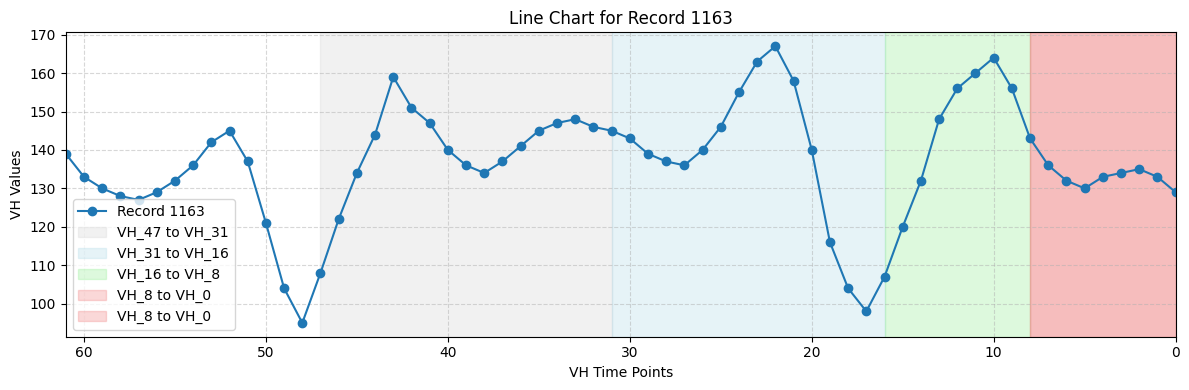

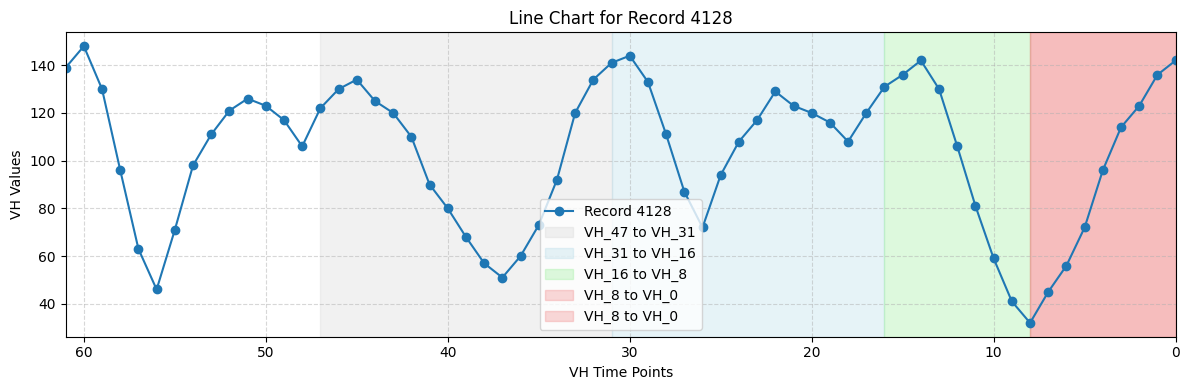

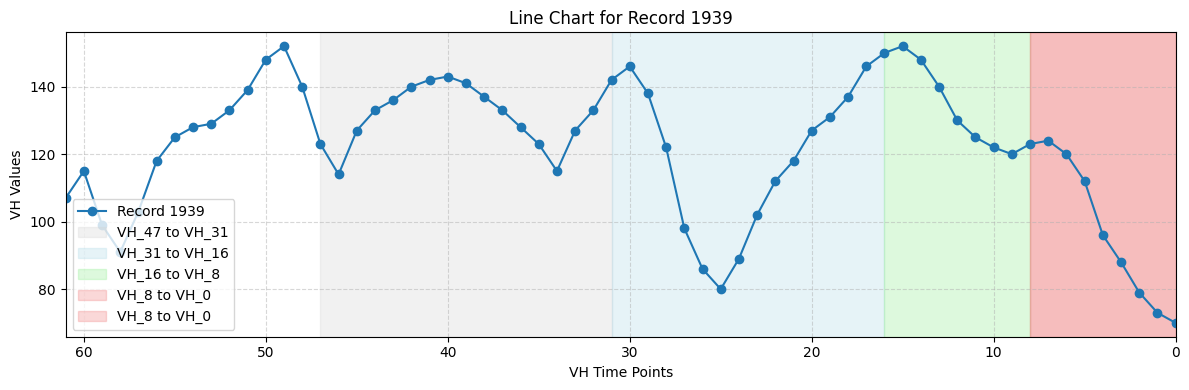

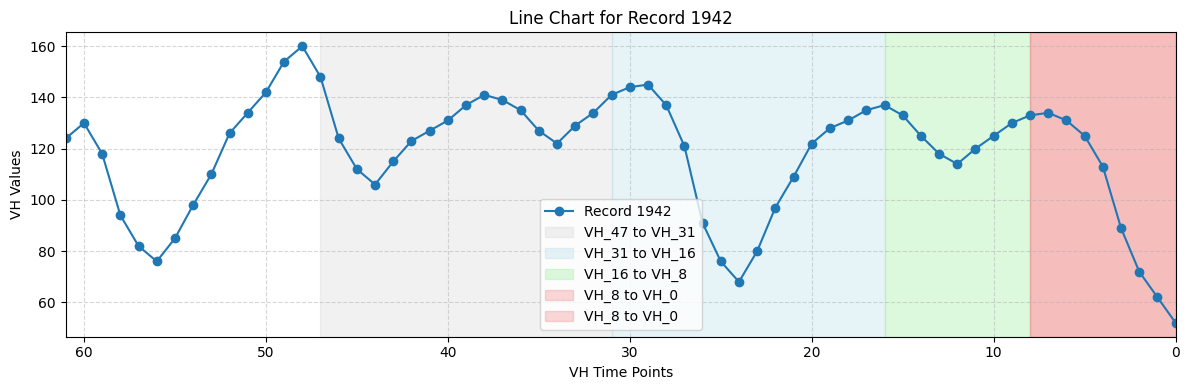

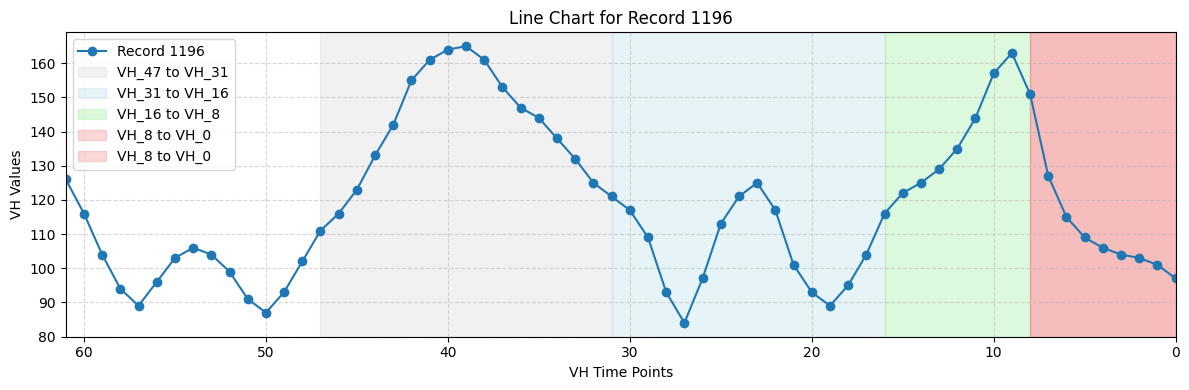

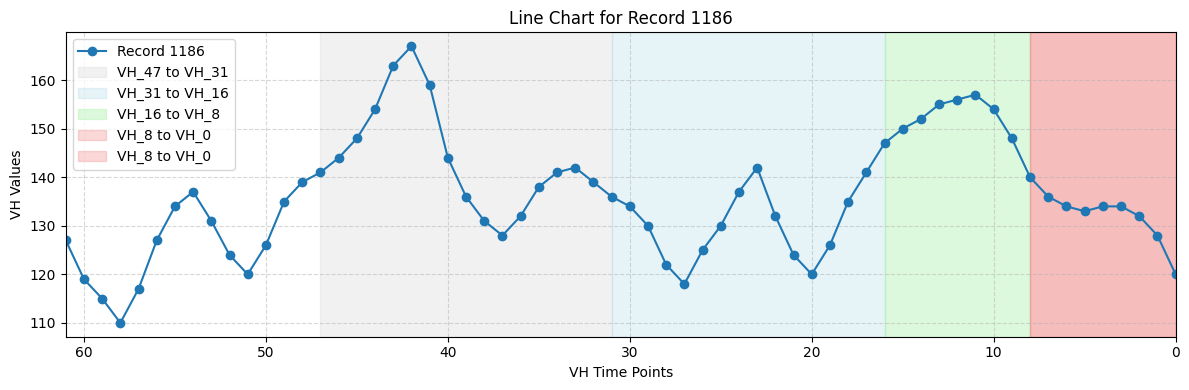

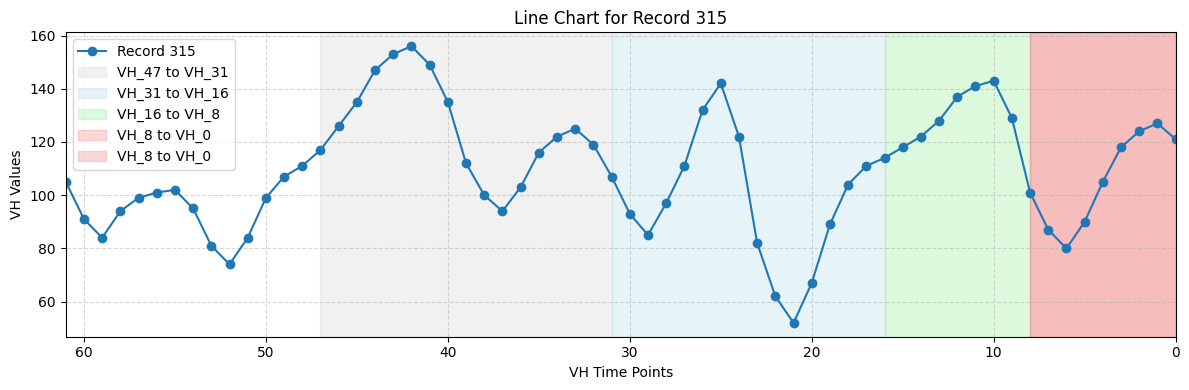

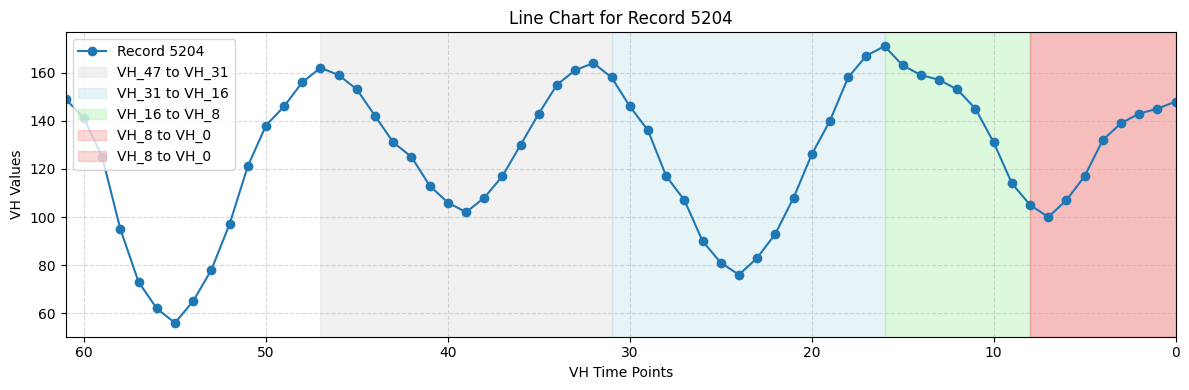

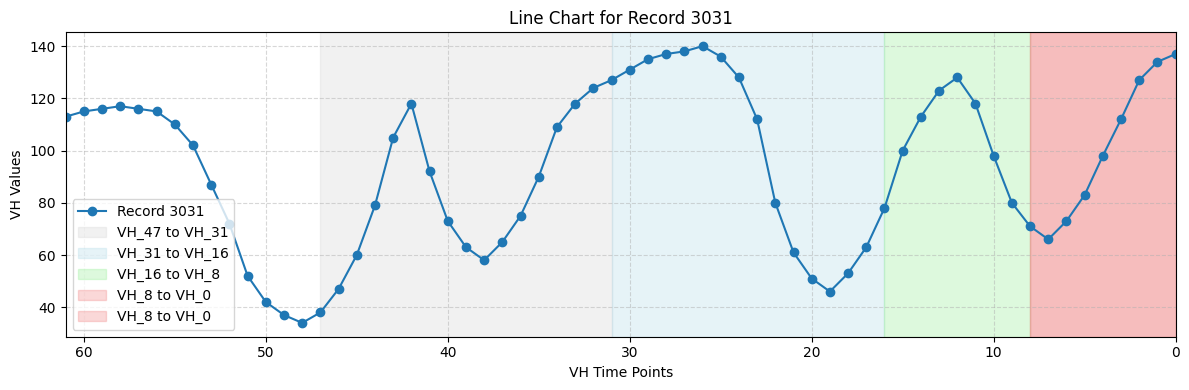

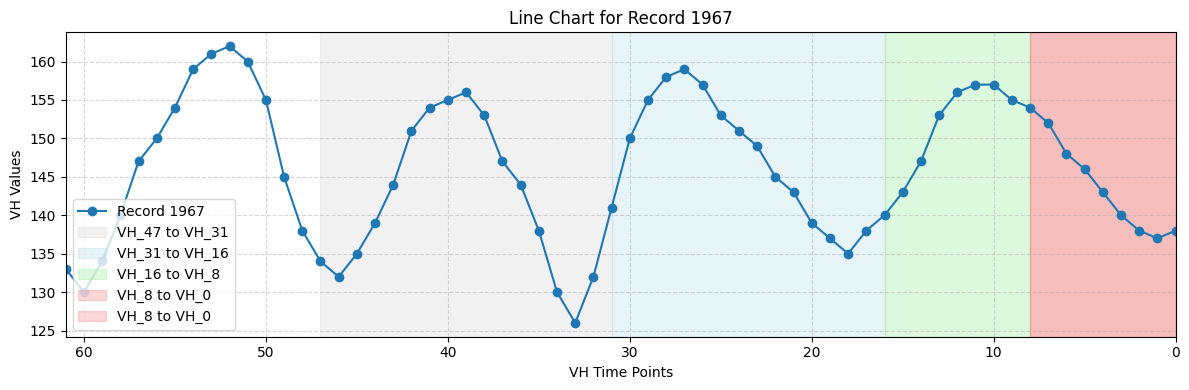

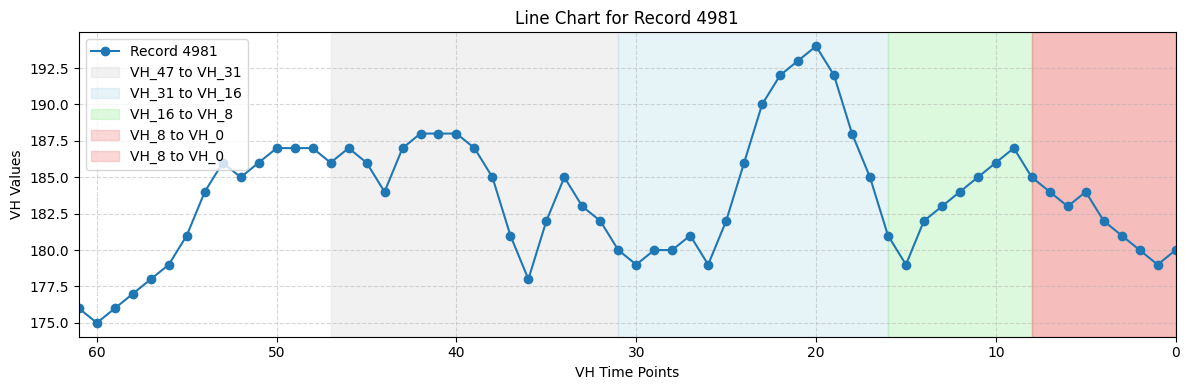

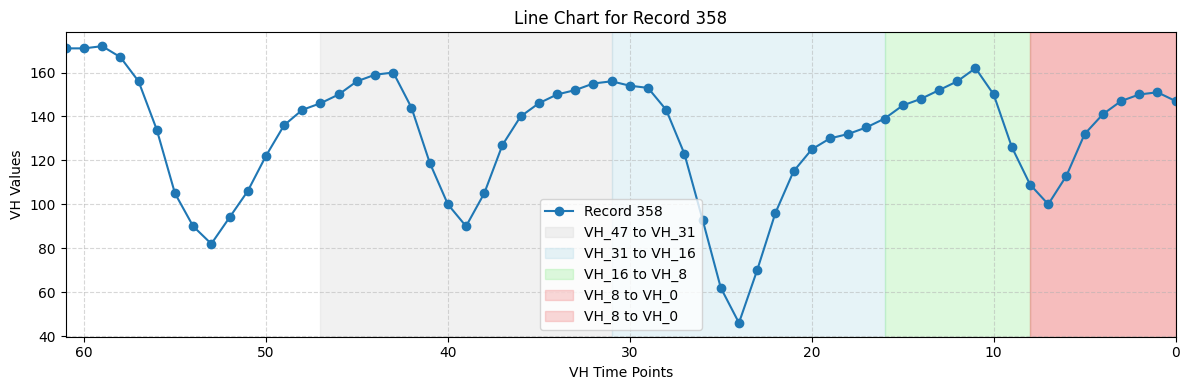

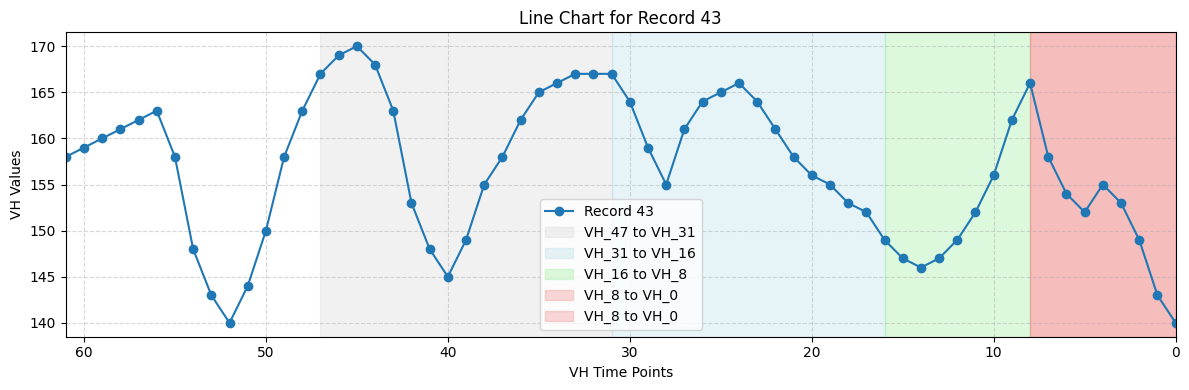

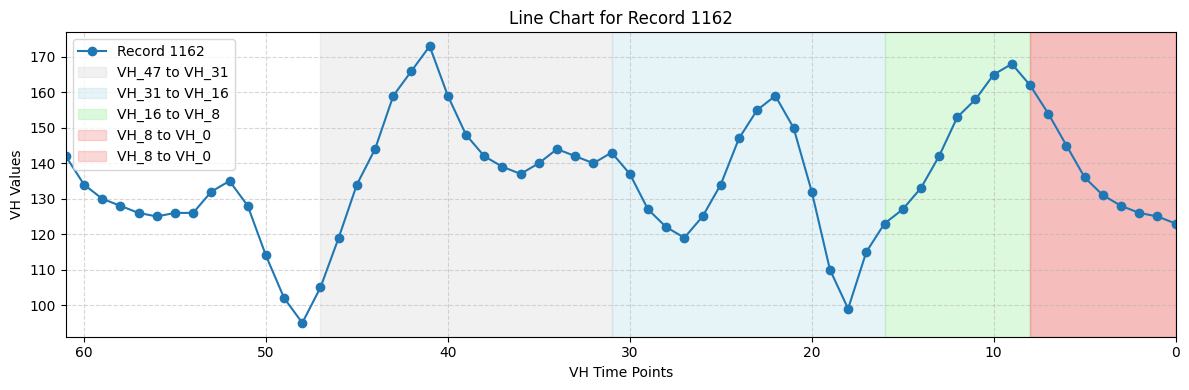

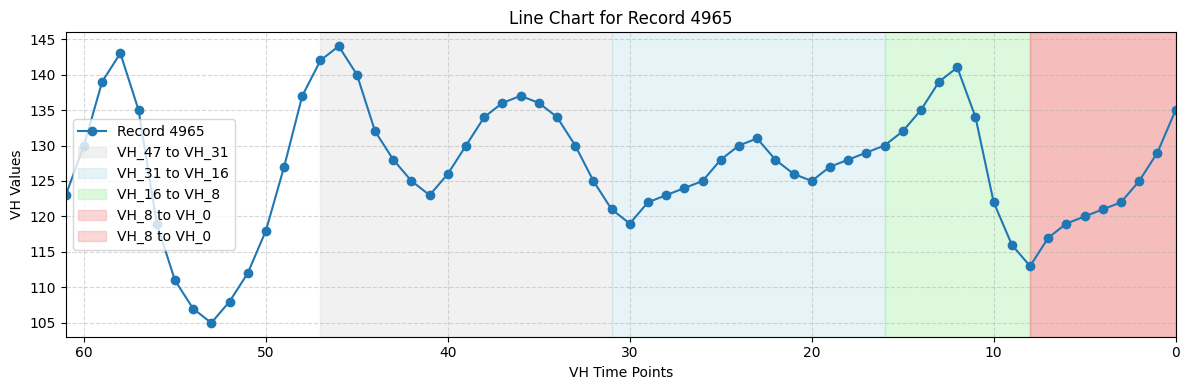

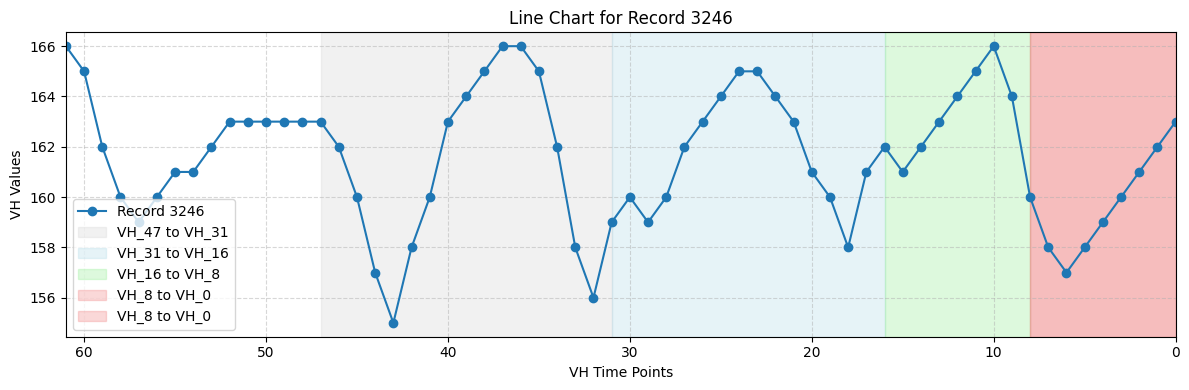

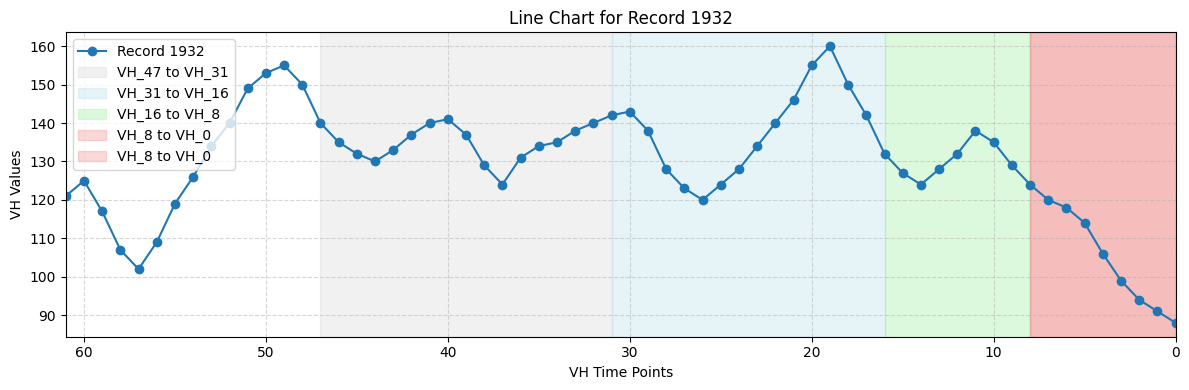

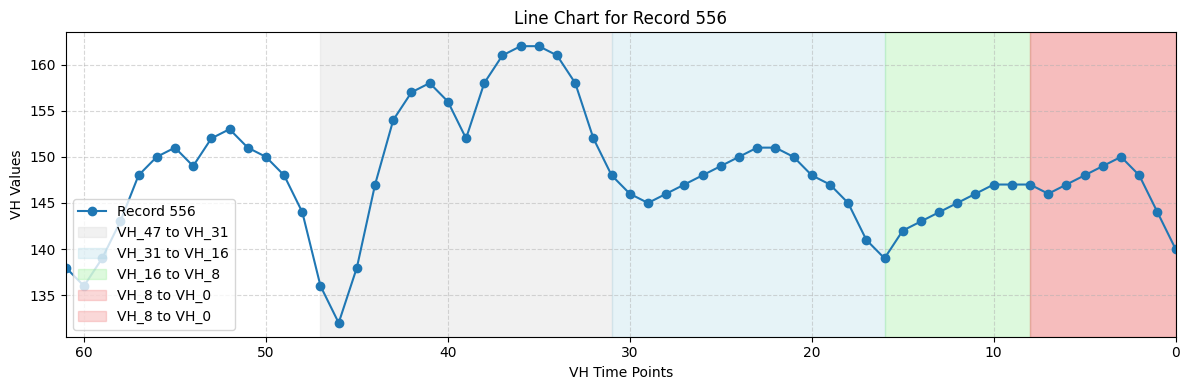

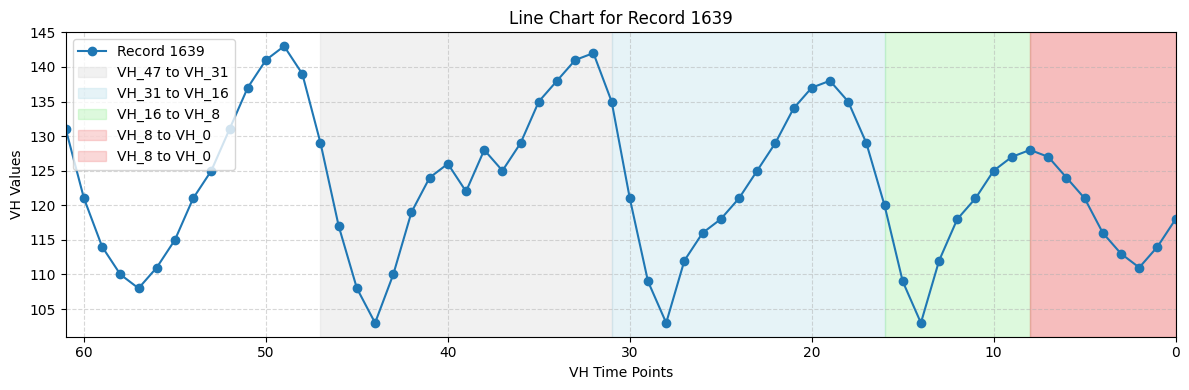

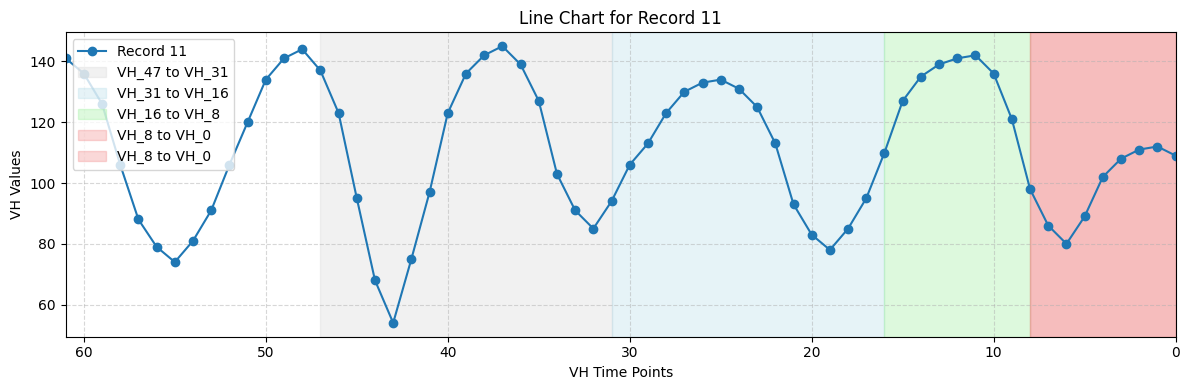

In [4]:
## Visualize PUSO

# Sample 20 records
sampled_df = data.query("is_puso == 1").sample(20, random_state=123)

# Plot line charts for each record
for _, row in sampled_df.iterrows():
    # Extract VH columns
    vh_values = row[[f'VH_{i}' for i in range(61, -1, -1)]].astype(float).values
    time_points = list(range(61, -1, -1))  # Time points from VH_61 to VH_0
    
    # Plot the line chart
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(time_points, vh_values, marker='o', label=f"Record {int(row['Unnamed: 0'])}")
    
    # Add background colors for specific regions
    ax.axvspan(31, 47, color='lightgrey', alpha=0.3, label='VH_47 to VH_31')
    ax.axvspan(16, 31, color='lightblue', alpha=0.3, label='VH_31 to VH_16')
    ax.axvspan(8, 16, color='lightgreen', alpha=0.3, label='VH_16 to VH_8')
    ax.axvspan(0, 8, color='lightcoral', alpha=0.3, label='VH_8 to VH_0')
    
    # Customize chart
    ax.set_title(f"Line Chart for Record {int(row['Unnamed: 0'])}")
    ax.set_xlabel("VH Time Points")
    ax.set_ylabel("VH Values")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlim(61, 0)  # Reverse X-axis to align VH_61 to VH_0 left-to-right
    
    # Save or show the plot
    plt.tight_layout()
    plt.show()

## Preparation

In [5]:
# Recode Observation

data['obs'] = data['obs'].replace({1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6})
data['obs'] = data['obs'].apply(lambda x: 7 if str(x).startswith('7') else x)
data['obs'] = data['obs'].apply(lambda x: 3 if str(x).startswith('3') else x)
data = data.loc[data['obs'] != 12.0]
data.head(2)

,Unnamed: 0,idsubsegmen_repair,obs,tahun,bulan,kdprov,idsubfinal,idkab,idkec,idsegmen,...,VH_9,VH_8,VH_7,VH_6,VH_5,VH_4,VH_3,VH_2,VH_1,VH_0
0,0,320104008A1,6.0,23,9,32,320104008A1239,3201,3201040,320104008,...,151,146,143,137,133,130,125,132,135,129
1,1,320104008A2,6.0,23,9,32,320104008A2239,3201,3201040,320104008,...,156,150,146,140,137,135,134,137,140,141


In [6]:
# data['obs2'] = data['obs'].replace({1.0: 1, 2.0: 1, 3.0: 1, 4.0: 2, 5.0: 3, 6.0: 4})
# data['obs2'] = data['obs2'].apply(lambda x: 5 if str(x).startswith('7') else x)
# data['obs2'] = data['obs2'].apply(lambda x: 1 if str(x).startswith('3') else x)
# data = data.loc[data['obs2'] != 12.0]
# data.head(2)

In [9]:
## Function Definition

def training(X, y, scenario_name): 
    # Split data into train-test (70%-30%)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=1234
    )
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)  # Majority/Minority class ratio
    
    # Stratified 3-Fold Cross Validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
    metrics = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx, :], X_train.iloc[val_idx, :]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
        # Train XGBoost model
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=1234,
                                  scale_pos_weight=scale_pos_weight, n_jobs=16)
        model.fit(X_train_fold, y_train_fold)
    
        # Predict on validation data
        y_pred = model.predict(X_val_fold)
        y_prob = model.predict_proba(X_val_fold)[:, 1]  # Probabilities for positive class
    
        # Calculate metrics
        precision = precision_score(y_val_fold, y_pred, average=None, zero_division=0)
        recall = recall_score(y_val_fold, y_pred, average=None, zero_division=0)
        accuracy = accuracy_score(y_val_fold, y_pred)
        f1_macro = f1_score(y_val_fold, y_pred, average="macro")
        auc = roc_auc_score(y_val_fold, y_prob)
    
        metrics.append({
            "precision_per_class": precision,
            "recall_per_class": recall,
            "accuracy": accuracy,
            "f1_macro": f1_macro,
            "auc": auc
        })

    # Compute average metrics across folds
    avg_precision = np.mean([m["precision_per_class"] for m in metrics], axis=0)
    avg_recall = np.mean([m["recall_per_class"] for m in metrics], axis=0)
    avg_accuracy = np.mean([m["accuracy"] for m in metrics])
    avg_f1_macro = np.mean([m["f1_macro"] for m in metrics])
    avg_auc = np.mean([m["auc"] for m in metrics])
    
    print(f"Average Metrics across Folds ({scenario_name}):")
    print("Precision per class:", avg_precision)
    print("Recall per class:", avg_recall)
    print("Accuracy:", avg_accuracy)
    print("F1-Macro:", avg_f1_macro)
    print("AUC ROC:", avg_auc)
    
    # Train final model on the full training set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({scenario_name})")
    plt.show()

    # Feature importance
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False).head(8)
    print(f"\n Top 8 Features ({scenario_name}):\n", importance_df)

    # Final Metrics
    precision_test = precision_score(y_test, y_test_pred, average=None, zero_division=0)
    recall_test = recall_score(y_test, y_test_pred, average=None, zero_division=0)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_macro_test = f1_score(y_test, y_test_pred, average="macro")
    auc_test = roc_auc_score(y_test, y_test_prob)
    
    print(f"\nPrecision per class (Test) ({scenario_name}):", precision_test)
    print(f"Recall per class (Test) ({scenario_name}):", recall_test)
    print(f"Accuracy (Test) ({scenario_name}):", accuracy_test)
    print(f"F1-Macro (Test) ({scenario_name}):", f1_macro_test)
    print(f"AUC ROC (Test) ({scenario_name}):", auc_test)
    
    # Classification Report
    print(f"\nClassification Report (Test) ({scenario_name}):")
    print(classification_report(y_test, y_test_pred, target_names=["Class 0", "Class 1"]))
    
    # Return metrics for the current scenario
    return {
        "scenario": scenario_name,
        "precision_class_0": avg_precision[0],
        "precision_class_1": avg_precision[1],
        "recall_class_0": avg_recall[0],
        "recall_class_1": avg_recall[1],
        "accuracy": avg_accuracy,
        "f1_macro": avg_f1_macro,
        "auc": avg_auc,
        "precision_test_class_0": precision_test[0],
        "precision_test_class_1": precision_test[1],
        "recall_test_class_0": recall_test[0],
        "recall_test_class_1": recall_test[1],
        "accuracy_test": accuracy_test,
        "f1_macro_test": f1_macro_test,
        "auc_test": auc_test,
        "top_5_features": importance_df
    }


## VH Only

In [10]:
# List to store metrics for comparison across scenarios
all_metrics = []

Index(['VH_7', 'VH_6', 'VH_5', 'VH_4', 'VH_3', 'VH_2', 'VH_1', 'VH_0'], dtype='object')
Average Metrics across Folds (3 Bulan):
Precision per class: [0.89144295 0.26602775]
Recall per class: [0.90143347 0.24640985]
Accuracy: 0.8181095152299506
F1-Macro: 0.5757693321745957
AUC ROC: 0.642958703081474


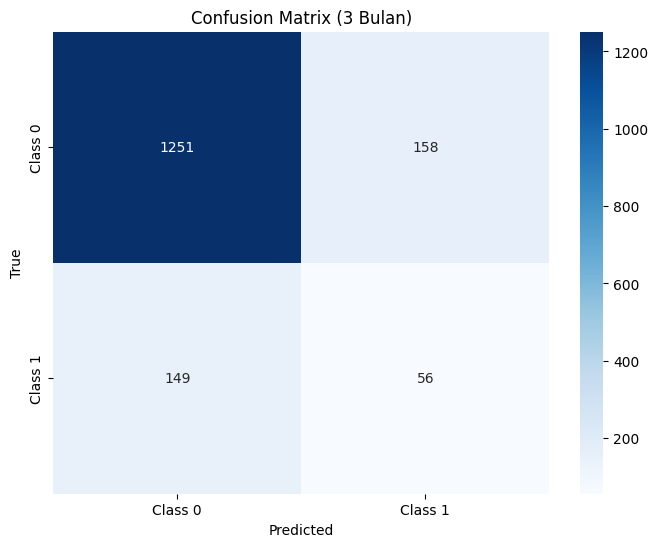


 Top 8 Features (3 Bulan):
   Feature  Importance
3    VH_4    0.160069
7    VH_0    0.142653
5    VH_2    0.124662
0    VH_7    0.117454
6    VH_1    0.117221
4    VH_3    0.114150
2    VH_5    0.112444
1    VH_6    0.111347

Precision per class (Test) (3 Bulan): [0.89357143 0.26168224]
Recall per class (Test) (3 Bulan): [0.88786373 0.27317073]
Accuracy (Test) (3 Bulan): 0.8097893432465924
F1-Macro (Test) (3 Bulan): 0.5790057698957749
AUC ROC (Test) (3 Bulan): 0.6585469715591407

Classification Report (Test) (3 Bulan):
              precision    recall  f1-score   support

     Class 0       0.89      0.89      0.89      1409
     Class 1       0.26      0.27      0.27       205

    accuracy                           0.81      1614
   macro avg       0.58      0.58      0.58      1614
weighted avg       0.81      0.81      0.81      1614



In [11]:
# Skenario 1 : 3 Bulan

X = data.iloc[:,-8:]
y = data["is_puso"]
print(X.columns)
metrics_3bulan = training(X, y, "3 Bulan")
all_metrics.append(metrics_3bulan)

Index(['VH_15', 'VH_14', 'VH_13', 'VH_12', 'VH_11', 'VH_10', 'VH_9', 'VH_8',
       'VH_7', 'VH_6', 'VH_5', 'VH_4', 'VH_3', 'VH_2', 'VH_1', 'VH_0'],
      dtype='object')
Average Metrics across Folds (6 Bulan):
Precision per class: [0.90029325 0.39271366]
Recall per class: [0.93581086 0.28818134]
Accuracy: 0.8534251528916182
F1-Macro: 0.6242054112822407
AUC ROC: 0.6798220167828605


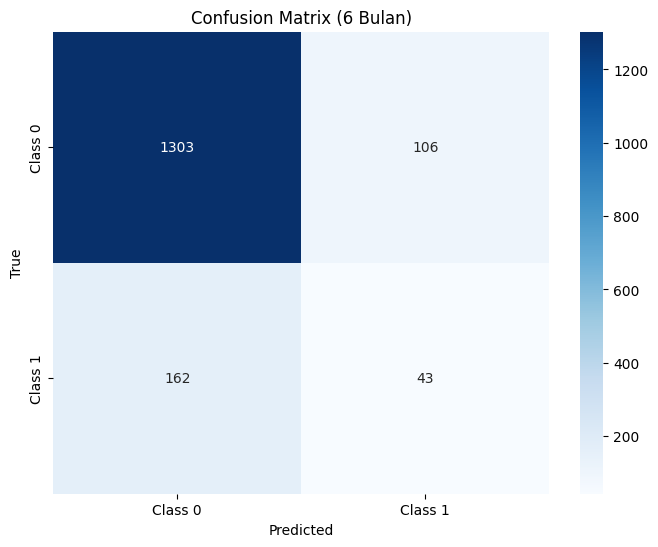


 Top 8 Features (6 Bulan):
    Feature  Importance
11    VH_4    0.080981
4    VH_11    0.079600
15    VH_0    0.074358
10    VH_5    0.071292
2    VH_13    0.069817
13    VH_2    0.069601
7     VH_8    0.064494
14    VH_1    0.061051

Precision per class (Test) (6 Bulan): [0.8894198 0.2885906]
Recall per class (Test) (6 Bulan): [0.92476934 0.2097561 ]
Accuracy (Test) (6 Bulan): 0.8339529120198265
F1-Macro (Test) (6 Bulan): 0.5748440135404503
AUC ROC (Test) (6 Bulan): 0.6631930620228841

Classification Report (Test) (6 Bulan):
              precision    recall  f1-score   support

     Class 0       0.89      0.92      0.91      1409
     Class 1       0.29      0.21      0.24       205

    accuracy                           0.83      1614
   macro avg       0.59      0.57      0.57      1614
weighted avg       0.81      0.83      0.82      1614



In [12]:
# Skenario 2 : 6 Bulan

X = data.iloc[:,-16:]
y = data["is_puso"]
print(X.columns)
metrics_6bulan = training(X, y, "6 Bulan")
all_metrics.append(metrics_6bulan)

Index(['VH_30', 'VH_29', 'VH_28', 'VH_27', 'VH_26', 'VH_25', 'VH_24', 'VH_23',
       'VH_22', 'VH_21', 'VH_20', 'VH_19', 'VH_18', 'VH_17', 'VH_16', 'VH_15',
       'VH_14', 'VH_13', 'VH_12', 'VH_11', 'VH_10', 'VH_9', 'VH_8', 'VH_7',
       'VH_6', 'VH_5', 'VH_4', 'VH_3', 'VH_2', 'VH_1', 'VH_0'],
      dtype='object')
Average Metrics across Folds (1 Tahun):
Precision per class: [0.90097642 0.46138841]
Recall per class: [0.95193425 0.28187893]
Accuracy: 0.866702404818095
F1-Macro: 0.637348952986222
AUC ROC: 0.7118118446279063


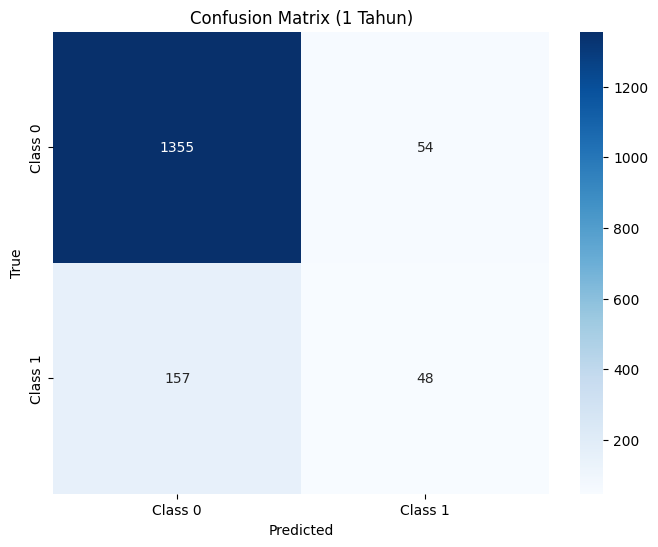


 Top 8 Features (1 Tahun):
    Feature  Importance
9    VH_21    0.051556
20   VH_10    0.045281
25    VH_5    0.044507
30    VH_0    0.041661
3    VH_27    0.040503
27    VH_3    0.040368
7    VH_23    0.036003
19   VH_11    0.035870

Precision per class (Test) (1 Tahun): [0.89616402 0.47058824]
Recall per class (Test) (1 Tahun): [0.96167495 0.23414634]
Accuracy (Test) (1 Tahun): 0.869268897149938
F1-Macro (Test) (1 Tahun): 0.6202340236432349
AUC ROC (Test) (1 Tahun): 0.6781214838408143

Classification Report (Test) (1 Tahun):
              precision    recall  f1-score   support

     Class 0       0.90      0.96      0.93      1409
     Class 1       0.47      0.23      0.31       205

    accuracy                           0.87      1614
   macro avg       0.68      0.60      0.62      1614
weighted avg       0.84      0.87      0.85      1614



In [13]:
# Skenario 3 : 12 Bulan

X = data.iloc[:,-31:]
y = data["is_puso"]
print(X.columns)
metrics_1tahun = training(X, y, "1 Tahun")
all_metrics.append(metrics_1tahun)

Index(['VH_61', 'VH_60', 'VH_59', 'VH_58', 'VH_57', 'VH_56', 'VH_55', 'VH_54',
       'VH_53', 'VH_52', 'VH_51', 'VH_50', 'VH_49', 'VH_48', 'VH_47', 'VH_46',
       'VH_45', 'VH_44', 'VH_43', 'VH_42', 'VH_41', 'VH_40', 'VH_39', 'VH_38',
       'VH_37', 'VH_36', 'VH_35', 'VH_34', 'VH_33', 'VH_32', 'VH_31', 'VH_30',
       'VH_29', 'VH_28', 'VH_27', 'VH_26', 'VH_25', 'VH_24', 'VH_23', 'VH_22',
       'VH_21', 'VH_20', 'VH_19', 'VH_18', 'VH_17', 'VH_16', 'VH_15', 'VH_14',
       'VH_13', 'VH_12', 'VH_11', 'VH_10', 'VH_9', 'VH_8', 'VH_7', 'VH_6',
       'VH_5', 'VH_4', 'VH_3', 'VH_2', 'VH_1', 'VH_0'],
      dtype='object')
Average Metrics across Folds (2 Tahun):
Precision per class: [0.90295325 0.54440494]
Recall per class: [0.9650135  0.28816824]
Accuracy: 0.8789170282775479
F1-Macro: 0.6545962105852549
AUC ROC: 0.7288529797439542


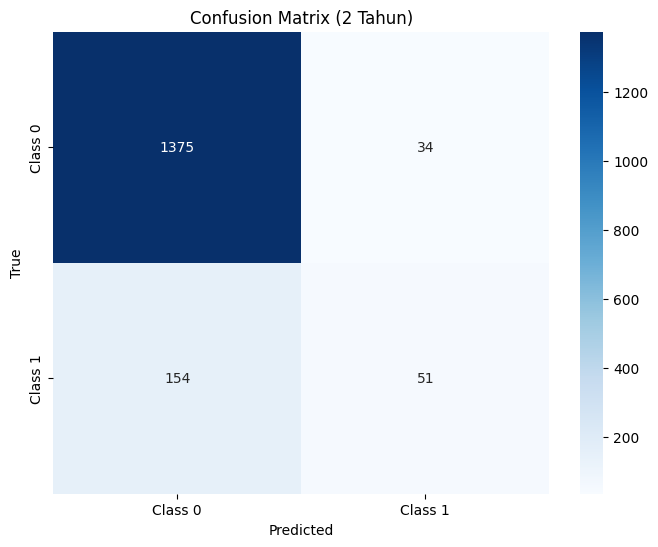


 Top 8 Features (2 Tahun):
    Feature  Importance
56    VH_5    0.030802
40   VH_21    0.027082
51   VH_10    0.026439
13   VH_48    0.026365
50   VH_11    0.024926
34   VH_27    0.024452
39   VH_22    0.024424
53    VH_8    0.023936

Precision per class (Test) (2 Tahun): [0.89928058 0.6       ]
Recall per class (Test) (2 Tahun): [0.97586941 0.24878049]
Accuracy (Test) (2 Tahun): 0.8835192069392813
F1-Macro (Test) (2 Tahun): 0.6438675148470693
AUC ROC (Test) (2 Tahun): 0.7115996468694281

Classification Report (Test) (2 Tahun):
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94      1409
     Class 1       0.60      0.25      0.35       205

    accuracy                           0.88      1614
   macro avg       0.75      0.61      0.64      1614
weighted avg       0.86      0.88      0.86      1614



In [14]:
# Skenario 4 : 24 Bulan
X = data.iloc[:,-62:]
y = data["is_puso"]
print(X.columns)
metrics_1tahun = training(X, y, "2 Tahun")
all_metrics.append(metrics_1tahun)

In [15]:
# Metrics of Model Validation 

metrics_df = pd.DataFrame(all_metrics)
metrics_df[['scenario', 'precision_class_0', 'precision_class_1', 'recall_class_0',
       'recall_class_1', 'accuracy', 'f1_macro', 'auc']]

,scenario,precision_class_0,precision_class_1,recall_class_0,recall_class_1,accuracy,f1_macro,auc
0,3 Bulan,0.891443,0.266028,0.901433,0.246410,0.818110,0.575769,0.642959
1,6 Bulan,0.900293,0.392714,0.935811,0.288181,0.853425,0.624205,0.679822
2,1 Tahun,0.900976,0.461388,0.951934,0.281879,0.866702,0.637349,0.711812
3,2 Tahun,0.902953,0.544405,0.965013,0.288168,0.878917,0.654596,0.728853


In [16]:
# Metrics of Data Test

metrics_df = pd.DataFrame(all_metrics)
metrics_df[['scenario','precision_test_class_0', 'precision_test_class_1',
       'recall_test_class_0', 'recall_test_class_1', 'accuracy_test',
       'f1_macro_test', 'auc_test']]

,scenario,precision_test_class_0,precision_test_class_1,recall_test_class_0,recall_test_class_1,accuracy_test,f1_macro_test,auc_test
0,3 Bulan,0.893571,0.261682,0.887864,0.273171,0.809789,0.579006,0.658547
1,6 Bulan,0.889420,0.288591,0.924769,0.209756,0.833953,0.574844,0.663193
2,1 Tahun,0.896164,0.470588,0.961675,0.234146,0.869269,0.620234,0.678121
3,2 Tahun,0.899281,0.600000,0.975869,0.248780,0.883519,0.643868,0.711600


In [17]:
all_metrics_VH = all_metrics
# all_metrics_VH

## VH & Difference

In [18]:
# List to store metrics for comparison across scenarios
all_metrics = []

Index([     0,      1,      2,      3,      4,      5,      6,      7, 'VH_8',
       'VH_7', 'VH_6', 'VH_5', 'VH_4', 'VH_3', 'VH_2', 'VH_1', 'VH_0'],
      dtype='object')
Average Metrics across Folds (ADD DIFF 3 BULAN):
Precision per class: [0.8907922  0.33844628]
Recall per class: [0.94037207 0.20881813]
Accuracy: 0.8473171010226609
F1-Macro: 0.5862973358012914
AUC ROC: 0.6555982760607587


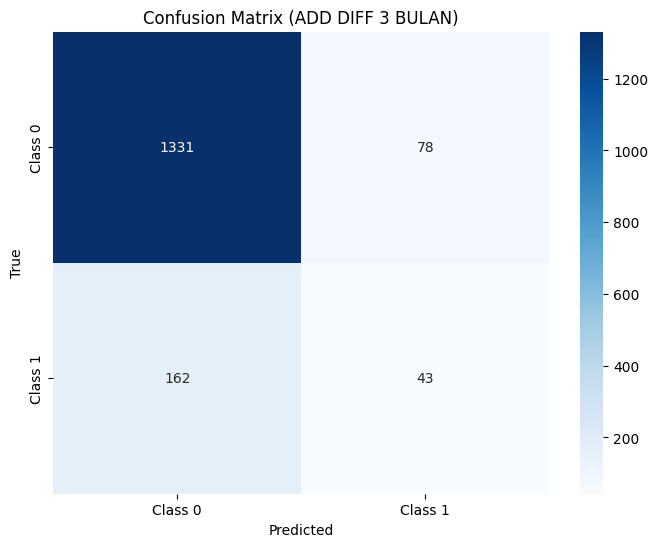


 Top 8 Features (ADD DIFF 3 BULAN):
    Feature  Importance
11    VH_5    0.073607
6        6    0.068138
7        7    0.066885
16    VH_0    0.066858
14    VH_2    0.066539
13    VH_3    0.065790
4        4    0.061735
5        5    0.057976

Precision per class (Test) (ADD DIFF 3 BULAN): [0.89149364 0.3553719 ]
Recall per class (Test) (ADD DIFF 3 BULAN): [0.94464159 0.2097561 ]
Accuracy (Test) (ADD DIFF 3 BULAN): 0.8513011152416357
F1-Macro (Test) (ADD DIFF 3 BULAN): 0.5905510479339402
AUC ROC (Test) (ADD DIFF 3 BULAN): 0.6211739860478803

Classification Report (Test) (ADD DIFF 3 BULAN):
              precision    recall  f1-score   support

     Class 0       0.89      0.94      0.92      1409
     Class 1       0.36      0.21      0.26       205

    accuracy                           0.85      1614
   macro avg       0.62      0.58      0.59      1614
weighted avg       0.82      0.85      0.83      1614



In [19]:
## 3 Bulan

data_slice_1 = data.iloc[:, -39:-31]
data_slice_2 = data.iloc[:, -8:]
result = data_slice_2.values - data_slice_1.values
X = pd.DataFrame(result)

X = X.join(data.iloc[:,-9:])
y = data["is_puso"]
print(X.columns)
metrics_ = training(X, y, "ADD DIFF 3 BULAN")
all_metrics.append(metrics_)

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
       'VH_15', 'VH_14', 'VH_13', 'VH_12', 'VH_11', 'VH_10',  'VH_9',  'VH_8',
        'VH_7',  'VH_6',  'VH_5',  'VH_4',  'VH_3',  'VH_2',  'VH_1',  'VH_0'],
      dtype='object')
Average Metrics across Folds (ADD DIFF 6 BULAN):
Precision per class: [0.89568844 0.42802422]
Recall per class: [0.95345382 0.23801101]
Accuracy: 0.8624531597601103
F1-Macro: 0.6146265543581657
AUC ROC: 0.7022825466077606


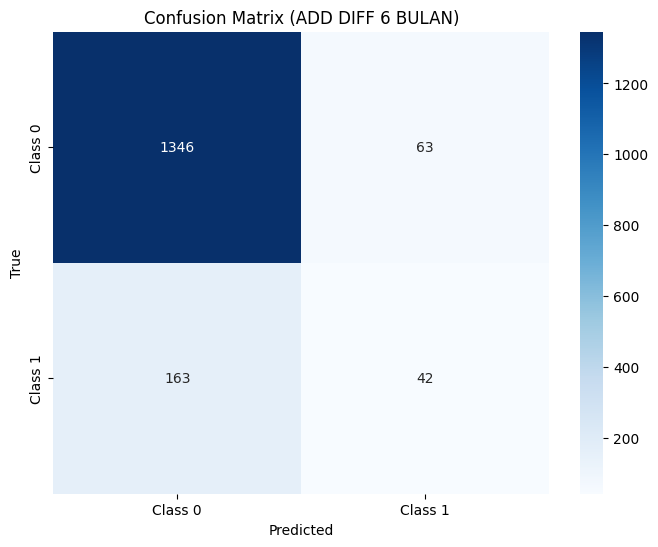


 Top 8 Features (ADD DIFF 6 BULAN):
    Feature  Importance
20   VH_11    0.056215
14      14    0.054771
21   VH_10    0.045664
28    VH_3    0.045183
31    VH_0    0.039973
29    VH_2    0.036005
30    VH_1    0.035577
27    VH_4    0.035433

Precision per class (Test) (ADD DIFF 6 BULAN): [0.89198144 0.4       ]
Recall per class (Test) (ADD DIFF 6 BULAN): [0.95528744 0.20487805]
Accuracy (Test) (ADD DIFF 6 BULAN): 0.8599752168525403
F1-Macro (Test) (ADD DIFF 6 BULAN): 0.5967587167525261
AUC ROC (Test) (ADD DIFF 6 BULAN): 0.67850750402465

Classification Report (Test) (ADD DIFF 6 BULAN):
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92      1409
     Class 1       0.40      0.20      0.27       205

    accuracy                           0.86      1614
   macro avg       0.65      0.58      0.60      1614
weighted avg       0.83      0.86      0.84      1614



In [20]:
## 6 Bulan

data_slice_1 = data.iloc[:, -47:-31]
data_slice_2 = data.iloc[:, -16:]
result = data_slice_2.values - data_slice_1.values
X = pd.DataFrame(result)

X = X.join(data.iloc[:,-16:])
y = data["is_puso"]
print(X.columns)
metrics_ = training(X, y, "ADD DIFF 6 BULAN")
all_metrics.append(metrics_)

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30, 'VH_30',
       'VH_29', 'VH_28', 'VH_27', 'VH_26', 'VH_25', 'VH_24', 'VH_23', 'VH_22',
       'VH_21', 'VH_20', 'VH_19', 'VH_18', 'VH_17', 'VH_16', 'VH_15', 'VH_14',
       'VH_13', 'VH_12', 'VH_11', 'VH_10',  'VH_9',  'VH_8',  'VH_7',  'VH_6',
        'VH_5',  'VH_4',  'VH_3',  'VH_2',  'VH_1',  'VH_0'],
      dtype='object')
Average Metrics across Folds (ADD DIFF 12 BULAN):
Precision per class: [0.90315024 0.58492697]
Recall per class: [0.97018548 0.2860456 ]
Accuracy: 0.8831643701203679
F1-Macro: 0.6595540107965965
AUC ROC: 0.7375261192761752


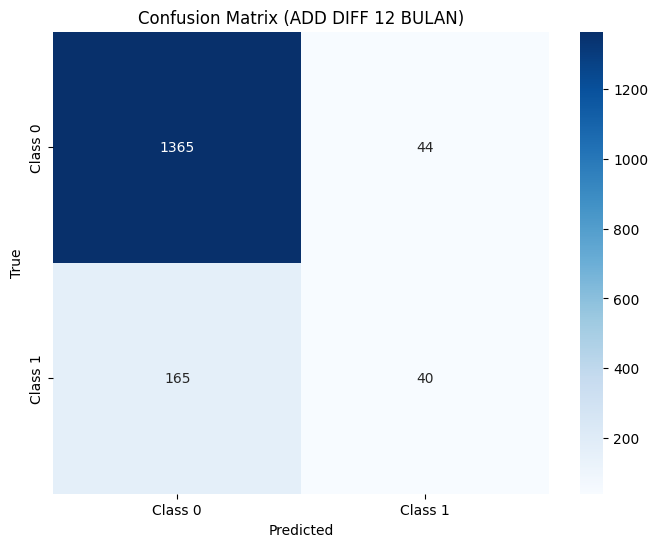


 Top 8 Features (ADD DIFF 12 BULAN):
    Feature  Importance
50   VH_11    0.041519
29      29    0.038246
51   VH_10    0.029853
61    VH_0    0.028553
41   VH_20    0.027807
34   VH_27    0.024869
26      26    0.023056
40   VH_21    0.022623

Precision per class (Test) (ADD DIFF 12 BULAN): [0.89215686 0.47619048]
Recall per class (Test) (ADD DIFF 12 BULAN): [0.96877218 0.19512195]
Accuracy (Test) (ADD DIFF 12 BULAN): 0.8705080545229245
F1-Macro (Test) (ADD DIFF 12 BULAN): 0.6028519928276337
AUC ROC (Test) (ADD DIFF 12 BULAN): 0.6576606830653118

Classification Report (Test) (ADD DIFF 12 BULAN):
              precision    recall  f1-score   support

     Class 0       0.89      0.97      0.93      1409
     Class 1       0.48      0.20      0.28       205

    accuracy                           0.87      1614
   macro avg       0.68      0.58      0.60      1614
weighted avg       0.84      0.87      0.85      1614



In [21]:
## 12 Bulan

data_slice_1 = data.iloc[:, -62:-31]
data_slice_2 = data.iloc[:, -31:]
result = data_slice_2.values - data_slice_1.values
X = pd.DataFrame(result)

X = X.join(data.iloc[:,-31:])
y = data["is_puso"]
print(X.columns)
metrics_ = training(X, y, "ADD DIFF 12 BULAN")
all_metrics.append(metrics_)

In [22]:
# Metrics of Model Validation 

metrics_df = pd.DataFrame(all_metrics)
metrics_df[['scenario', 'precision_class_0', 'precision_class_1', 'recall_class_0',
       'recall_class_1', 'accuracy', 'f1_macro', 'auc']]

,scenario,precision_class_0,precision_class_1,recall_class_0,recall_class_1,accuracy,f1_macro,auc
0,ADD DIFF 3 BULAN,0.890792,0.338446,0.940372,0.208818,0.847317,0.586297,0.655598
1,ADD DIFF 6 BULAN,0.895688,0.428024,0.953454,0.238011,0.862453,0.614627,0.702283
2,ADD DIFF 12 BULAN,0.903150,0.584927,0.970185,0.286046,0.883164,0.659554,0.737526


In [23]:
# Metrics of Data Test

metrics_df = pd.DataFrame(all_metrics)
metrics_df[['scenario','precision_test_class_0', 'precision_test_class_1',
       'recall_test_class_0', 'recall_test_class_1', 'accuracy_test',
       'f1_macro_test', 'auc_test']]

,scenario,precision_test_class_0,precision_test_class_1,recall_test_class_0,recall_test_class_1,accuracy_test,f1_macro_test,auc_test
0,ADD DIFF 3 BULAN,0.891494,0.355372,0.944642,0.209756,0.851301,0.590551,0.621174
1,ADD DIFF 6 BULAN,0.891981,0.400000,0.955287,0.204878,0.859975,0.596759,0.678508
2,ADD DIFF 12 BULAN,0.892157,0.476190,0.968772,0.195122,0.870508,0.602852,0.657661


## Multiclass

In [24]:
def training_multiclass(X, y, scenario_name): 
    
    # Initialize LabelEncoder
    le = LabelEncoder()
    
    # Fit the encoder on the labels (y) and transform them
    y_encoded = le.fit_transform(y.astype(str))  # Ensure labels are strings before encoding
    
    # Split data into train-test (70%-30%)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=1234
    )
    
    # Calculate scale_pos_weight for imbalanced classes (example assumes class '6.0')
    scale_pos_weight = np.sum(y_train != le.transform(['6.0'])[0]) / np.sum(y_train == le.transform(['6.0'])[0])
    print(f"Scale Pos Weight: {scale_pos_weight}")
    
    # Stratified 3-Fold Cross Validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
    metrics = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx, :], X_train.iloc[val_idx, :]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
        # Train XGBoost model with scale_pos_weight
        model = xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric="mlogloss",
            random_state=1234,
            scale_pos_weight=scale_pos_weight,
            n_jobs=16
        )
        model.fit(X_train_fold, y_train_fold)
    
        # Predict on validation data
        y_pred = model.predict(X_val_fold)
        y_prob = model.predict_proba(X_val_fold)  # Probabilities for all classes
    
        # Calculate metrics for multiclass
        precision = precision_score(y_val_fold, y_pred, average=None, zero_division=0)
        recall = recall_score(y_val_fold, y_pred, average=None, zero_division=0)
        accuracy = accuracy_score(y_val_fold, y_pred)
        f1_macro = f1_score(y_val_fold, y_pred, average="macro")
        auc = roc_auc_score(y_val_fold, y_prob, multi_class="ovr", average="macro")  # Multiclass AUC ROC
    
        metrics.append({
            "precision_per_class": precision,
            "recall_per_class": recall,
            "accuracy": accuracy,
            "f1_macro": f1_macro,
            "auc": auc
        })

    # Compute average metrics across folds
    avg_precision = np.mean([m["precision_per_class"] for m in metrics], axis=0)
    avg_recall = np.mean([m["recall_per_class"] for m in metrics], axis=0)
    avg_accuracy = np.mean([m["accuracy"] for m in metrics])
    avg_f1_macro = np.mean([m["f1_macro"] for m in metrics])
    avg_auc = np.mean([m["auc"] for m in metrics])
    
    print("Average Metrics across Folds:")
    print("Precision per class:", avg_precision)
    print("Recall per class:", avg_recall)
    print("Accuracy:", avg_accuracy)
    print("F1-Macro:", avg_f1_macro)
    print("AUC ROC:", avg_auc)
    
    # Evaluate on test set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)  # Probabilities for all classes
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Feature Importance
    feature_importances = model.feature_importances_
    top_features = pd.DataFrame({
        "Feature": X.columns,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False).head(8)
    print("\nTop 8 Important Features:")
    print(top_features)
    
    # Final Metrics
    precision_test = precision_score(y_test, y_test_pred, average=None, zero_division=0)
    recall_test = recall_score(y_test, y_test_pred, average=None, zero_division=0)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_macro_test = f1_score(y_test, y_test_pred, average="macro")
    auc_test = roc_auc_score(y_test, y_test_prob, multi_class="ovr", average="macro")
    
    print("\n Precision per class (Test):", precision_test)
    print("Recall per class (Test):", recall_test)
    print("Accuracy (Test):", accuracy_test)
    print("F1-Macro (Test):", f1_macro_test)
    print("AUC ROC (Test):", auc_test)
    
    # Classification Report
    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_test_pred, target_names=[f"Class {i}" for i in le.classes_]))
    
    
    # Return metrics for the current scenario
    return {
        "scenario": scenario_name,
        "precision_class_6": avg_precision[le.transform(['6.0'])[0]],  # Precision for class '6.0'
        "recall_class_6": avg_recall[le.transform(['6.0'])[0]],  # Recall for class '6.0'
        "accuracy": avg_accuracy,
        "f1_macro": avg_f1_macro,
        "auc": avg_auc,
        "precision_test_class_6": precision_test[le.transform(['6.0'])[0]],  # Precision for class '6.0' in test
        "recall_test_class_6": recall_test[le.transform(['6.0'])[0]],  # Recall for class '6.0' in test
        "accuracy_test": accuracy_test,
        "f1_macro_test": f1_macro_test,
        "auc_test": auc_test,
        "top_features": top_features
    }


In [25]:
# List to store metrics for comparison across scenarios
all_metrics = []

Index(['VH_7', 'VH_6', 'VH_5', 'VH_4', 'VH_3', 'VH_2', 'VH_1', 'VH_0'], dtype='object')
Scale Pos Weight: 6.862212943632568
Average Metrics across Folds:
Precision per class: [0.42290075 0.32541515 0.39381926 0.37086196 0.32467193 0.3062744
 0.24044689 0.25468005]
Recall per class: [0.41350211 0.28620407 0.42976939 0.48890536 0.22580645 0.26307652
 0.21935711 0.20539931]
Accuracy: 0.3422769643295185
F1-Macro: 0.3198149634532729
AUC ROC: 0.733269206181682


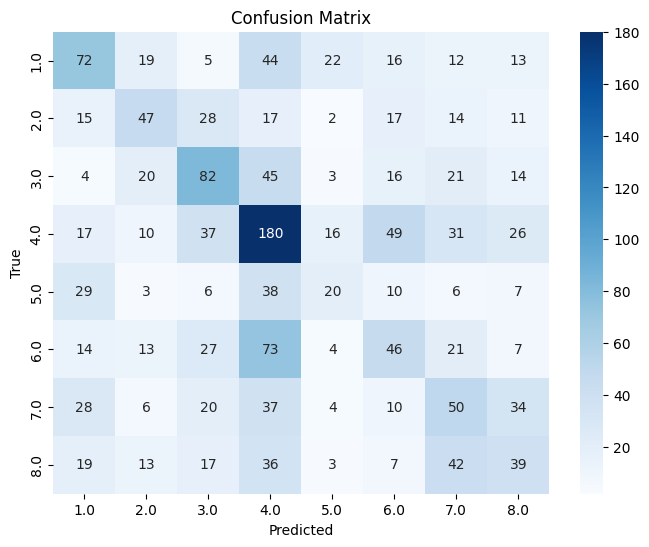


Top 8 Important Features:
  Feature  Importance
7    VH_0    0.157673
5    VH_2    0.138275
0    VH_7    0.125387
2    VH_5    0.120338
1    VH_6    0.119448
3    VH_4    0.119390
4    VH_3    0.112573
6    VH_1    0.106916

 Precision per class (Test): [0.36363636 0.35877863 0.36936937 0.38297872 0.27027027 0.26900585
 0.25380711 0.25827815]
Recall per class (Test): [0.3546798  0.31125828 0.4        0.49180328 0.16806723 0.22439024
 0.26455026 0.22159091]
Accuracy (Test): 0.33209417596034696
F1-Macro (Test): 0.3070833416778273
AUC ROC (Test): 0.7283572323215558

Classification Report (Test):
              precision    recall  f1-score   support

   Class 1.0       0.36      0.35      0.36       203
   Class 2.0       0.36      0.31      0.33       151
   Class 3.0       0.37      0.40      0.38       205
   Class 4.0       0.38      0.49      0.43       366
   Class 5.0       0.27      0.17      0.21       119
   Class 6.0       0.27      0.22      0.24       205
   Class 7.0       0

In [26]:
## 3 Bulan - Multiclass
X = data.iloc[:,-8:]
y = data["obs"].astype('str')
print(X.columns)
metrics_ = training_multiclass(X, y, "3 bulan - multiclass")
all_metrics.append(metrics_)

Index(['VH_15', 'VH_14', 'VH_13', 'VH_12', 'VH_11', 'VH_10', 'VH_9', 'VH_8',
       'VH_7', 'VH_6', 'VH_5', 'VH_4', 'VH_3', 'VH_2', 'VH_1', 'VH_0'],
      dtype='object')
Scale Pos Weight: 6.862212943632568
Average Metrics across Folds:
Precision per class: [0.44858961 0.33163296 0.41185557 0.41108818 0.38363095 0.37234362
 0.25091799 0.24144178]
Recall per class: [0.45780591 0.28045777 0.44654088 0.52874145 0.26523297 0.28182652
 0.2466446  0.2201052 ]
Accuracy: 0.3685626919075291
F1-Macro: 0.34468251798411814
AUC ROC: 0.7503332009551885


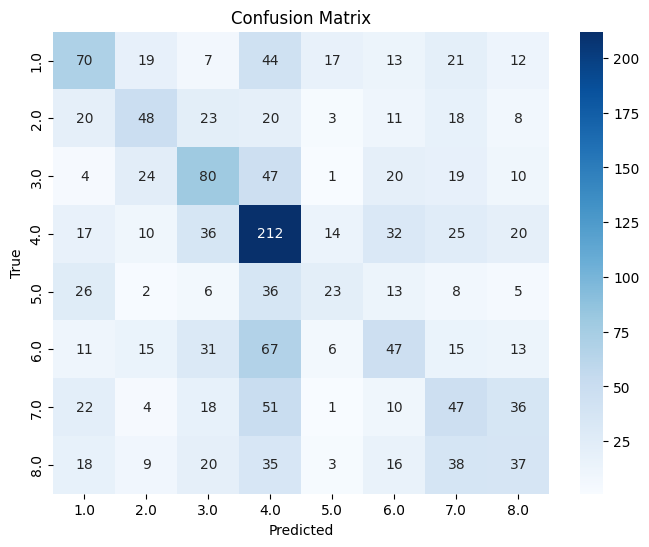


Top 8 Important Features:
   Feature  Importance
15    VH_0    0.087798
6     VH_9    0.070820
9     VH_6    0.069406
10    VH_5    0.068663
13    VH_2    0.067222
11    VH_4    0.064714
3    VH_12    0.062648
12    VH_3    0.062558

 Precision per class (Test): [0.37234043 0.36641221 0.36199095 0.4140625  0.33823529 0.29012346
 0.2460733  0.26241135]
Recall per class (Test): [0.34482759 0.31788079 0.3902439  0.57923497 0.19327731 0.22926829
 0.24867725 0.21022727]
Accuracy (Test): 0.34944237918215615
F1-Macro (Test): 0.31748892147001545
AUC ROC (Test): 0.7480485158951864

Classification Report (Test):
              precision    recall  f1-score   support

   Class 1.0       0.37      0.34      0.36       203
   Class 2.0       0.37      0.32      0.34       151
   Class 3.0       0.36      0.39      0.38       205
   Class 4.0       0.41      0.58      0.48       366
   Class 5.0       0.34      0.19      0.25       119
   Class 6.0       0.29      0.23      0.26       205
   Class 7

In [27]:
## 6 Bulan - Multiclass
X = data.iloc[:,-16:]
y = data["obs"].astype('str')
print(X.columns)
metrics_ = training_multiclass(X, y, "6 bulan - multiclass")
all_metrics.append(metrics_)

Index(['VH_30', 'VH_29', 'VH_28', 'VH_27', 'VH_26', 'VH_25', 'VH_24', 'VH_23',
       'VH_22', 'VH_21', 'VH_20', 'VH_19', 'VH_18', 'VH_17', 'VH_16', 'VH_15',
       'VH_14', 'VH_13', 'VH_12', 'VH_11', 'VH_10', 'VH_9', 'VH_8', 'VH_7',
       'VH_6', 'VH_5', 'VH_4', 'VH_3', 'VH_2', 'VH_1', 'VH_0'],
      dtype='object')
Scale Pos Weight: 6.862212943632568
Average Metrics across Folds:
Precision per class: [0.44153989 0.40529906 0.42598485 0.41927083 0.4001061  0.41483248
 0.27661659 0.26829544]
Recall per class: [0.47468354 0.31450094 0.4360587  0.55448892 0.25089606 0.32350629
 0.27151131 0.24690497]
Accuracy: 0.3884749748352661
F1-Macro: 0.36448467064129875
AUC ROC: 0.7636118151027061


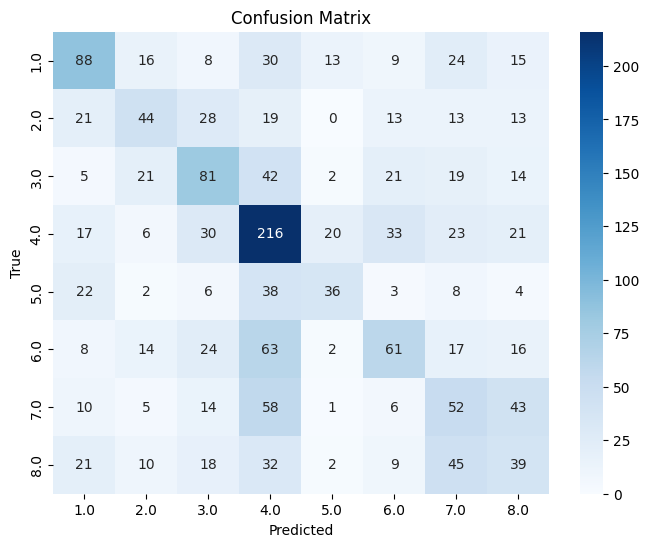


Top 8 Important Features:
   Feature  Importance
30    VH_0    0.050508
21    VH_9    0.042831
24    VH_6    0.042522
25    VH_5    0.039774
3    VH_27    0.039291
26    VH_4    0.038985
28    VH_2    0.037180
20   VH_10    0.036293

 Precision per class (Test): [0.45833333 0.37288136 0.38755981 0.43373494 0.47368421 0.39354839
 0.25870647 0.23636364]
Recall per class (Test): [0.43349754 0.29139073 0.39512195 0.59016393 0.30252101 0.29756098
 0.27513228 0.22159091]
Accuracy (Test): 0.3822800495662949
F1-Macro (Test): 0.3584421052833161
AUC ROC (Test): 0.7694286645806745

Classification Report (Test):
              precision    recall  f1-score   support

   Class 1.0       0.46      0.43      0.45       203
   Class 2.0       0.37      0.29      0.33       151
   Class 3.0       0.39      0.40      0.39       205
   Class 4.0       0.43      0.59      0.50       366
   Class 5.0       0.47      0.30      0.37       119
   Class 6.0       0.39      0.30      0.34       205
   Class 7.0

In [28]:
##  12 Bulan - Multiclass

X = data.iloc[:,-31:]
y = data["obs"].astype('str')
print(X.columns)
metrics_ = training_multiclass(X, y, "12 bulan - multiclass")
all_metrics.append(metrics_)

Index(['VH_61', 'VH_60', 'VH_59', 'VH_58', 'VH_57', 'VH_56', 'VH_55', 'VH_54',
       'VH_53', 'VH_52', 'VH_51', 'VH_50', 'VH_49', 'VH_48', 'VH_47', 'VH_46',
       'VH_45', 'VH_44', 'VH_43', 'VH_42', 'VH_41', 'VH_40', 'VH_39', 'VH_38',
       'VH_37', 'VH_36', 'VH_35', 'VH_34', 'VH_33', 'VH_32', 'VH_31', 'VH_30',
       'VH_29', 'VH_28', 'VH_27', 'VH_26', 'VH_25', 'VH_24', 'VH_23', 'VH_22',
       'VH_21', 'VH_20', 'VH_19', 'VH_18', 'VH_17', 'VH_16', 'VH_15', 'VH_14',
       'VH_13', 'VH_12', 'VH_11', 'VH_10', 'VH_9', 'VH_8', 'VH_7', 'VH_6',
       'VH_5', 'VH_4', 'VH_3', 'VH_2', 'VH_1', 'VH_0'],
      dtype='object')
Scale Pos Weight: 6.862212943632568
Average Metrics across Folds:
Precision per class: [0.4530119  0.38299082 0.44270898 0.43762937 0.43737292 0.46833613
 0.27709271 0.23876375]
Recall per class: [0.47046414 0.32582452 0.46331237 0.59674656 0.2688172  0.34027778
 0.25330943 0.22253829]
Accuracy: 0.4006961538136203
F1-Macro: 0.3737210242118194
AUC ROC: 0.7714120930930801


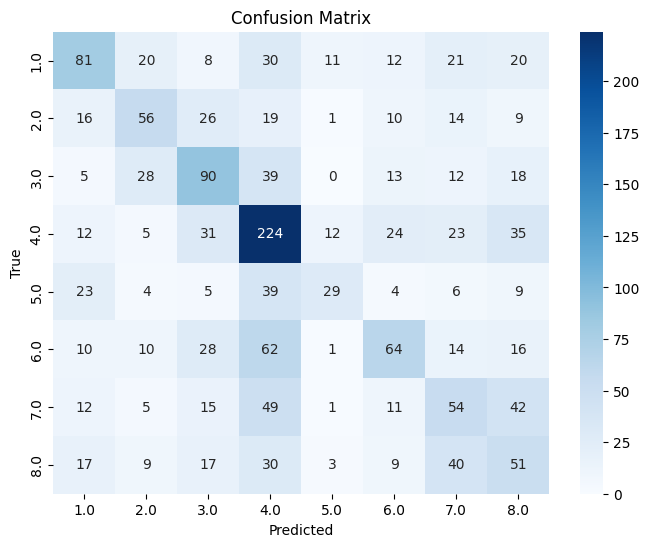


Top 8 Important Features:
   Feature  Importance
61    VH_0    0.032350
52    VH_9    0.028312
55    VH_6    0.025789
56    VH_5    0.025139
59    VH_2    0.024586
51   VH_10    0.022385
32   VH_29    0.022274
57    VH_4    0.021432

 Precision per class (Test): [0.46022727 0.40875912 0.40909091 0.45528455 0.5        0.43537415
 0.29347826 0.255     ]
Recall per class (Test): [0.39901478 0.37086093 0.43902439 0.61202186 0.24369748 0.31219512
 0.28571429 0.28977273]
Accuracy (Test): 0.4021065675340768
F1-Macro (Test): 0.3767680333960857
AUC ROC (Test): 0.7735748005225154

Classification Report (Test):
              precision    recall  f1-score   support

   Class 1.0       0.46      0.40      0.43       203
   Class 2.0       0.41      0.37      0.39       151
   Class 3.0       0.41      0.44      0.42       205
   Class 4.0       0.46      0.61      0.52       366
   Class 5.0       0.50      0.24      0.33       119
   Class 6.0       0.44      0.31      0.36       205
   Class 7.0

In [29]:
##  24 Bulan - Multiclass

X = data.iloc[:,-62:]
y = data["obs"].astype('str')
print(X.columns)
metrics_ = training_multiclass(X, y, "24 bulan - multiclass")
all_metrics.append(metrics_)

In [31]:
# Metrics of Model Validation 

metrics_df = pd.DataFrame(all_metrics)
metrics_df[['scenario', 'precision_class_6', 'recall_class_6', 'accuracy', 'f1_macro', 'auc']]

,scenario,precision_class_6,recall_class_6,accuracy,f1_macro,auc
0,3 bulan - multiclass,0.306274,0.263077,0.342277,0.319815,0.733269
1,6 bulan - multiclass,0.372344,0.281827,0.368563,0.344683,0.750333
2,12 bulan - multiclass,0.414832,0.323506,0.388475,0.364485,0.763612
3,24 bulan - multiclass,0.468336,0.340278,0.400696,0.373721,0.771412


In [32]:
# Metrics of Model Validation 

metrics_df = pd.DataFrame(all_metrics)
metrics_df[['scenario', 'precision_test_class_6', 'recall_test_class_6', 'accuracy_test', 'f1_macro_test', 'auc_test']]

,scenario,precision_test_class_6,recall_test_class_6,accuracy_test,f1_macro_test,auc_test
0,3 bulan - multiclass,0.269006,0.224390,0.332094,0.307083,0.728357
1,6 bulan - multiclass,0.290123,0.229268,0.349442,0.317489,0.748049
2,12 bulan - multiclass,0.393548,0.297561,0.382280,0.358442,0.769429
3,24 bulan - multiclass,0.435374,0.312195,0.402107,0.376768,0.773575


## Generate Maps

In [100]:
import rasterio
import numpy as np

raster_path = "../sentinel 1/S1VH_Jabar_50m_2020_sd_2023.tif"

# Open the raster file
with rasterio.open(raster_path) as src:

    crs = src.crs
    transform = src.transform

    raster_data = src.read()  
    num_bands, height, width = raster_data.shape
    band_names = [f"Band {i+1}" for i in range(num_bands)]

    src.close()

print("Raster Data Shape:", raster_data.shape)  # (num_bands, height, width)
# print("Band Names:", band_names)

Raster Data Shape: (124, 4343, 5678)


In [102]:
from rasterio.crs import CRS
manually_defined_crs = CRS.from_epsg(4326) 

print("CRS:", manually_defined_crs)
print("Transform:\n", transform)

CRS: EPSG:4326
Transform:
 | 0.00, 0.00, 106.35|
| 0.00,-0.00,-5.90|
| 0.00, 0.00, 1.00|


(24659554, 31)

In [107]:
## 12 Bulan

last_bands = raster_data[-31:, :, :]  # This will be (12, height, width)
last_bands_reshaped = last_bands.reshape(31, -1).T  # Shape: (num_pixels, 12)
last_bands_reshaped.shape

X = data.iloc[:,-31:]
y = data["is_puso"]
scale_pos_weight = np.sum(y == 0) / np.sum(y == 1)
model_fix = xgb.XGBClassifier(use_label_encoder=False,eval_metric="mlogloss",random_state=1234,
            scale_pos_weight=scale_pos_weight,n_jobs=16)
model_fix.fit(X, y)

predictions = model_fix.predict(last_bands_reshaped)  # Shape: (num_pixels,)
predictions_2d = predictions.reshape(height, width)
print("Predictions Shape:", predictions_2d.shape)  # Should be (height, width)

output_path = "predictions_output_202312_12_bulan.tif"
predictions_2d = predictions_2d.astype(np.uint8) 
no_data_value = 0

with rasterio.open(raster_path) as src:
    crs = src.crs
    transform = src.transform
    width = src.width
    height = src.height

# Export predictions as a new GeoTIFF
with rasterio.open(output_path, 'w', driver='GTiff',
                   count=1, dtype=predictions_2d.dtype, 
                   crs=crs, transform=transform, 
                   width=width, height=height,
                   nodata=no_data_value) as dst:
    dst.write(predictions_2d, 1)
    dst.close()

print(f"Predictions saved to: {output_path}")


Predictions Shape: (4343, 5678)
Predictions saved to: predictions_output_202312_12_bulan.tif


In [109]:
## 3 Bulan 

last_bands = raster_data[-8:, :, :]  # This will be (12, height, width)
last_bands_reshaped = last_bands.reshape(8, -1).T  # Shape: (num_pixels, 12)
last_bands_reshaped.shape

X = data.iloc[:,-8:]
y = data["is_puso"]
scale_pos_weight = np.sum(y == 0) / np.sum(y == 1)
model_fix = xgb.XGBClassifier(use_label_encoder=False,eval_metric="mlogloss",random_state=1234,
            scale_pos_weight=scale_pos_weight,n_jobs=16)
model_fix.fit(X, y)

predictions = model_fix.predict(last_bands_reshaped)  # Shape: (num_pixels,)
predictions_2d = predictions.reshape(height, width)
print("Predictions Shape:", predictions_2d.shape)  # Should be (height, width)

output_path = "predictions_output_202312_3_bulan.tif"
predictions_2d = predictions_2d.astype(np.uint8) 
no_data_value = 0

with rasterio.open(raster_path) as src:
    crs = src.crs
    transform = src.transform
    width = src.width
    height = src.height

# Export predictions as a new GeoTIFF
with rasterio.open(output_path, 'w', driver='GTiff',
                   count=1, dtype=predictions_2d.dtype, 
                   crs=crs, transform=transform, 
                   width=width, height=height,
                   nodata=no_data_value) as dst:
    dst.write(predictions_2d, 1)
    dst.close()

print(f"Predictions saved to: {output_path}")



Predictions Shape: (4343, 5678)
Predictions saved to: predictions_output_202312_3_bulan.tif


In [110]:
## 6 Bulan 

last_bands = raster_data[-16:, :, :]  # This will be (12, height, width)
last_bands_reshaped = last_bands.reshape(16, -1).T  # Shape: (num_pixels, 12)
last_bands_reshaped.shape

X = data.iloc[:,-16:]
y = data["is_puso"]
scale_pos_weight = np.sum(y == 0) / np.sum(y == 1)
model_fix = xgb.XGBClassifier(use_label_encoder=False,eval_metric="mlogloss",random_state=1234,
            scale_pos_weight=scale_pos_weight,n_jobs=16)
model_fix.fit(X, y)

predictions = model_fix.predict(last_bands_reshaped)  # Shape: (num_pixels,)
predictions_2d = predictions.reshape(height, width)
print("Predictions Shape:", predictions_2d.shape)  # Should be (height, width)

output_path = "predictions_output_202312_6_bulan.tif"
predictions_2d = predictions_2d.astype(np.uint8) 
no_data_value = 0

with rasterio.open(raster_path) as src:
    crs = src.crs
    transform = src.transform
    width = src.width
    height = src.height

# Export predictions as a new GeoTIFF
with rasterio.open(output_path, 'w', driver='GTiff',
                   count=1, dtype=predictions_2d.dtype, 
                   crs=crs, transform=transform, 
                   width=width, height=height,
                   nodata=no_data_value) as dst:
    dst.write(predictions_2d, 1)
    dst.close()

print(f"Predictions saved to: {output_path}")



Predictions Shape: (4343, 5678)
Predictions saved to: predictions_output_202312_6_bulan.tif


In [111]:
## 24 Bulan 

last_bands = raster_data[-62:, :, :]  # This will be (12, height, width)
last_bands_reshaped = last_bands.reshape(62, -1).T  # Shape: (num_pixels, 12)
last_bands_reshaped.shape

X = data.iloc[:,-62:]
y = data["is_puso"]
scale_pos_weight = np.sum(y == 0) / np.sum(y == 1)
model_fix = xgb.XGBClassifier(use_label_encoder=False,eval_metric="mlogloss",random_state=1234,
            scale_pos_weight=scale_pos_weight,n_jobs=16)
model_fix.fit(X, y)

predictions = model_fix.predict(last_bands_reshaped)  # Shape: (num_pixels,)
predictions_2d = predictions.reshape(height, width)
print("Predictions Shape:", predictions_2d.shape)  # Should be (height, width)

output_path = "predictions_output_202312_24_bulan.tif"
predictions_2d = predictions_2d.astype(np.uint8) 
no_data_value = 0

with rasterio.open(raster_path) as src:
    crs = src.crs
    transform = src.transform
    width = src.width
    height = src.height

# Export predictions as a new GeoTIFF
with rasterio.open(output_path, 'w', driver='GTiff',
                   count=1, dtype=predictions_2d.dtype, 
                   crs=crs, transform=transform, 
                   width=width, height=height,
                   nodata=no_data_value) as dst:
    dst.write(predictions_2d, 1)
    dst.close()

print(f"Predictions saved to: {output_path}")



Predictions Shape: (4343, 5678)
Predictions saved to: predictions_output_202312_24_bulan.tif


In [113]:
# Load the raster data (assuming you have the raster_path defined)
raster_path = "../sentinel 1/S1VH_Jabar_50m_2020_sd_2023.tif"
with rasterio.open(raster_path) as src:
    raster_data = src.read()

# Extract the last 12 bands (24 months)
last_bands = raster_data[-62:, :, :]  # Shape will be (12, height, width)
last_bands_reshaped = last_bands.reshape(62, -1).T  # Shape: (num_pixels, 12)

# Assuming 'data' contains your training features and labels
X = data.iloc[:, -62:]
y = data["is_puso"]

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = np.sum(y == 0) / np.sum(y == 1)

# Train the XGBoost model
model_fix = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=1234,
                              scale_pos_weight=scale_pos_weight, n_jobs=16)
model_fix.fit(X, y)

# Get class probabilities for the last 12 months' pixel values
pred_prob = model_fix.predict_proba(last_bands_reshaped)  # Shape: (num_pixels, 2)
class_1_prob = pred_prob[:, 1]  # Probability of class 1 (usually the second column)

# Reshape the probabilities to match the raster shape
prob_2d = class_1_prob.reshape(raster_data.shape[1], raster_data.shape[2])  # Shape: (height, width)

# Output file path
output_path = "predictions_output_202312_24_bulan_prob_class1.tif"

# Save the probability of class 1 as a new GeoTIFF
no_data_value = 0
with rasterio.open(raster_path) as src:
    crs = src.crs
    transform = src.transform
    width = src.width
    height = src.height

    with rasterio.open(output_path, 'w', driver='GTiff',
                       count=1, dtype=prob_2d.dtype, 
                       crs=crs, transform=transform, 
                       width=width, height=height,
                       nodata=no_data_value) as dst:
        dst.write(prob_2d, 1)

print(f"Predictions (Class 1 Probability) saved to: {output_path}")


Predictions (Class 1 Probability) saved to: predictions_output_202312_24_bulan_prob_class1.tif
